# Single Level with one classical mode

## Initialize variables and imports

In [1]:
import numpy
from scipy import linalg, special, integrate, optimize
from scipy.integrate import solve_ivp
import matplotlib
from matplotlib import pyplot

from tqdm.notebook import tqdm

import joblib

import born_markov as bmme

In [2]:
d_ops, d_dags = bmme.generate_fermionic_ops(1)
d1_op, d1_dag = d_ops[0], d_dags[0]

omega = .003
lamda = .02
epsilon = .15
Gamma = .005
Gammas = numpy.array([[[Gamma, Gamma]]])
T = .026 / bmme.k_B
voltage = 0.0

def func_H_s(x):
    H_s = .5 * (omega * x[0]**2) * numpy.identity(d1_op.shape[0])
    H_s += epsilon * d1_dag @ d1_op
    H_s += numpy.sqrt(2) * lamda * x[0] * d1_dag @ d1_op
    return H_s

def func_ddx_H_s(k, x):
    if k == 0:
        ddx = omega * x[0] * numpy.identity(d1_op.shape[0])
        ddx += numpy.sqrt(2) * lamda * d1_dag @ d1_op
        return ddx

## Calculate Langevin quantities

In [22]:
def my_func(i, val):
    return bmme.calc_langevin_quantities(func_H_s, func_ddx_H_s, val, d_ops, None, Gammas, -.5 * voltage, .5 * voltage, T, T, method="analytic", include_digamma=False)

#def my_func2(i, val):
#    solver = bmme.general_solver(func_H_s(val), d_ops, None, Gammas, -.5 * voltage, .5 * voltage, T, T, include_digamma=False)
#    r, L = solver.find_steady_state()
#    return solver.V @ r @ solver.V_dag

x1 = numpy.linspace(-1020, 1010, 200000)
#x1 = numpy.linspace(-20, 10, 2000)

mean_force = numpy.zeros(len(x1), dtype=numpy.float64)
friction = numpy.zeros(len(x1), dtype=numpy.float64)
correlation = numpy.zeros(len(x1), dtype=numpy.float64)

results = joblib.Parallel(n_jobs=4)(joblib.delayed(my_func)(i, [val]) for i, val in enumerate(tqdm(x1)))

for i in range(len(results)):
    mean_force[i] = results[i][0].real
    friction[i] = results[i][1].real
    correlation[i] = results[i][2].real

numpy.save("data/SL_1cl/mean_force_" + str(lamda) + "_voltage_" + str(voltage) + ".npy", numpy.array([x1, mean_force]))
numpy.save("data/SL_1cl/friction_" + str(lamda) + "_voltage_" + str(voltage) + ".npy", numpy.array([x1, friction]))
numpy.save("data/SL_1cl/correlation_" + str(lamda) + "_voltage_" + str(voltage) + ".npy", numpy.array([x1, correlation]))

## Load Langevin quantities and calculate PMF

In [3]:
import time

start = time.time()
friction0 = numpy.load("data/SL_1cl/friction_" + str(lamda) + "_voltage_" + str(voltage) + ".npy")
mean_force0 = numpy.load("data/SL_1cl/mean_force_" + str(lamda) + "_voltage_" + str(voltage) + ".npy")
correlation0 = numpy.load("data/SL_1cl/correlation_" + str(lamda) + "_voltage_" + str(voltage) + ".npy")
print(time.time() - start)

grid = mean_force0[0]
force = mean_force0[1]
gamma = friction0[1]
corr = correlation0[1]
mbaoab_F = force / omega
mbaoab_gamma = gamma
mbaoab_sigma = numpy.sqrt(corr / (2*omega)) #linalg.sqrtm(corr / 2)

def to_int_w_numpy_support(stuff):
    if isinstance(stuff, numpy.ndarray):
        return numpy.array(stuff, dtype=int)
    else:
        return int(stuff)

def get_lin_int(x, X):
    index_low = grid[0]
    index_high = grid[-1]
    index_l = to_int_w_numpy_support((x - index_low) * len(grid) / (index_high - index_low))
    index_h = index_l + 1
    x_1 = grid[index_l]
    x_2 = grid[index_h]
    
    x_target = x
    
    return (X[index_l] * (x_2 - x_target) + X[index_h] * (x_target - x_1)) / (x_2 - x_1)

def solve_mbaoab(x_0, v_0, N, dt=1e-2, K=10):
    factor = numpy.sqrt(dt / K)
    x = numpy.zeros(N+1)
    v = numpy.zeros(N+1)
    x[0] = x_0
    v[0] = v_0
    for i in tqdm(range(N)):
        x[i+1] = x[i] + 0.5 * dt * v[i]
        F = get_lin_int(x[i+1], mbaoab_F)
        gam = get_lin_int(x[i+1], mbaoab_gamma)
        sigma = get_lin_int(x[i+1], mbaoab_sigma)
        v[i+1] = v[i] + 0.5 * dt * F
        G = numpy.exp(-dt * gam / (2 * K))
        for j in range(K):
            v[i+1] = G * G * v[i+1] + factor * G * sigma * numpy.random.randn(1)
        v[i+1] += 0.5 * dt * F
        x[i+1] += 0.5 * dt * v[i+1]
    return x, v

pmf = numpy.zeros(len(grid), dtype=numpy.float64)
pmf_factor = (max(grid) - min(grid)) / (len(grid) - 1)
for i in tqdm(range(1, len(grid))):
    pmf[i] = pmf[i-1] - (force[i] * pmf_factor)
min_arg = numpy.argmin(pmf)
print(grid[min_arg])
pmf -= pmf[min_arg]
pmf /= omega

print(grid[numpy.argmin(numpy.abs(force))])

0.051859140396118164



-0.03155015775087122
-9.308696543482824


## Plot Langevin quantities

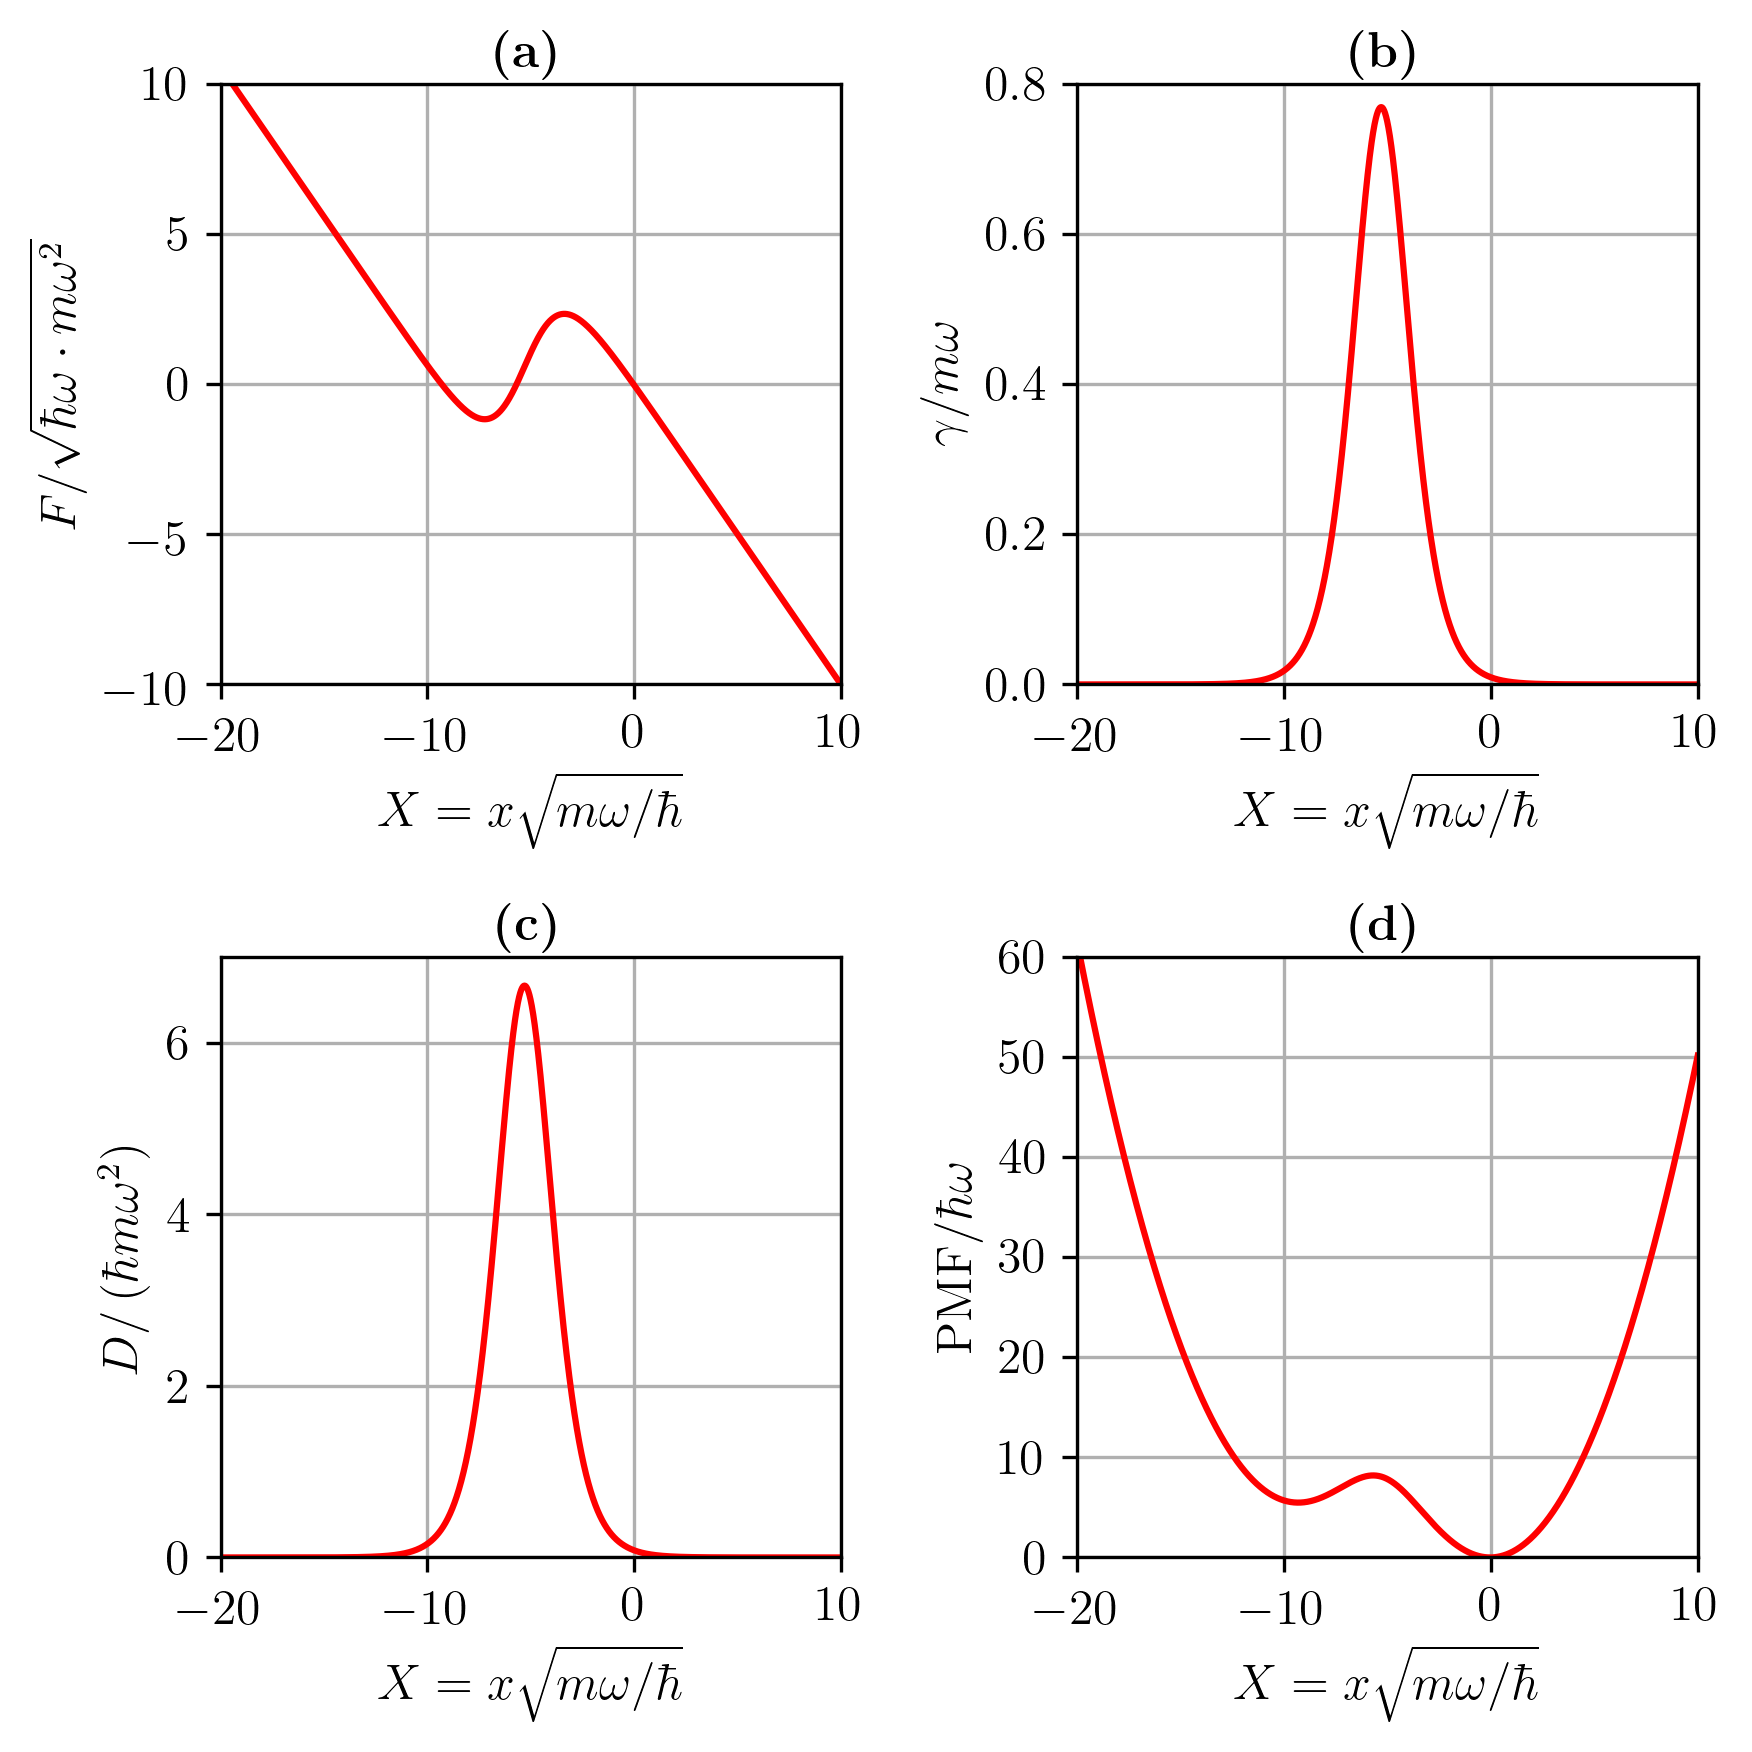

In [39]:
fig = pyplot.figure(figsize=(6, 6), tight_layout=True)
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

#[98500:101500]

def plot_axes(ax, data, label):
    ax.plot(grid[98500:101500], data, c="r")
    ax.set_xlabel("$X=x\\sqrt{m\\omega/\\hbar}$")
    ax.set_ylabel(label)
    ax.set_xlim(-20, 10)
    #ax.set_xticks([-40, -20, 0, 20, 40])
    #ax.set_ylim(-200, 200)
    #ax.set_yticks([-40, -20, 0, 20, 40])
    ax.grid()
    #ax1.text(-5., 1., "\\textbf{(a)}", ha="center", va="bottom")

plot_axes(ax1, force[98500:101500] / omega, "$F/\\sqrt{\\hbar\\omega\\cdot m\\omega^2}$")
#plot_axes(ax1, force[98500:101500], "$F/\\sqrt{m\\omega/\\hbar}$ [eV]")t

#print(grid[numpy.argmin(numpy.abs(force))])

plot_axes(ax2, gamma[98500:101500], "$\\gamma/m\\omega$")
#plot_axes(ax2, gamma[98500:101500], "$\\hbar\\gamma/m\\omega$ [$\\hbar$]")

plot_axes(ax3, corr[98500:101500] / omega, "$D/\\left(\\hbar m\\omega^2\\right)$")
#plot_axes(ax3, corr[98500:101500], "$\\hbar D/m\\omega$ [$\\hbar\\cdot\\mathrm{eV}$]")

plot_axes(ax4, pmf[98500:101500], "PMF$/\\hbar\\omega$")
#ax4.plot(grid[98500:101500], .5 * grid[98500:101500]**2, "--")

ax1.set_title("\\textbf{(a)}", fontdict={"fontsize":"medium"}, pad=4)
ax1.set_ylim(-10., 10.)
ax2.set_title("\\textbf{(b)}", fontdict={"fontsize":"medium"}, pad=4)
ax2.set_ylim(.0, .8)
ax3.set_title("\\textbf{(c)}", fontdict={"fontsize":"medium"}, pad=4)
ax3.set_ylim(.0, 7.)
ax4.set_title("\\textbf{(d)}", fontdict={"fontsize":"medium"}, pad=4)
ax4.set_ylim(.0, 60.)

pyplot.gcf().set_dpi(300)
pyplot.savefig("SL_1cl.pdf")
pyplot.show()

## Analyze purely quantum system

In [13]:
omega = omega
lamda = lamda
epsilon = epsilon
Gamma = Gamma
T = T
voltage = 0.0
N = 40

solver = bmme.create_holstein_solver(epsilon, omega, lamda, N, Gamma, -.5*voltage, .5*voltage, T, T, use_exp=True, include_digamma=False)

rho_ss, L = solver.find_steady_state()

#print(rho_ss)

#print(solver.d_ops[0])

pt = bmme.partial_trace(rho_ss, 2).real

print(numpy.array_str(pt, precision=3, suppress_small=True))

[[ 0.11  -0.     0.    ...  0.     0.     0.   ]
 [ 0.     0.098 -0.    ...  0.    -0.    -0.   ]
 [-0.    -0.     0.087 ...  0.    -0.     0.   ]
 ...
 [-0.     0.     0.    ...  0.002  0.     0.   ]
 [ 0.    -0.    -0.    ... -0.     0.001  0.   ]
 [ 0.    -0.     0.    ...  0.    -0.     0.001]]


## Plot Wigner function

In [14]:
def wigner(n):
    c = numpy.zeros(n+1)
    c[n] = 1
    return lambda x,p: (-1)**n * numpy.exp(-(x**2 + p**2)) * numpy.polynomial.laguerre.Laguerre(c)(2*(p**2 + x**2))

4.1652805709833505 +- 0.0002677498976537295


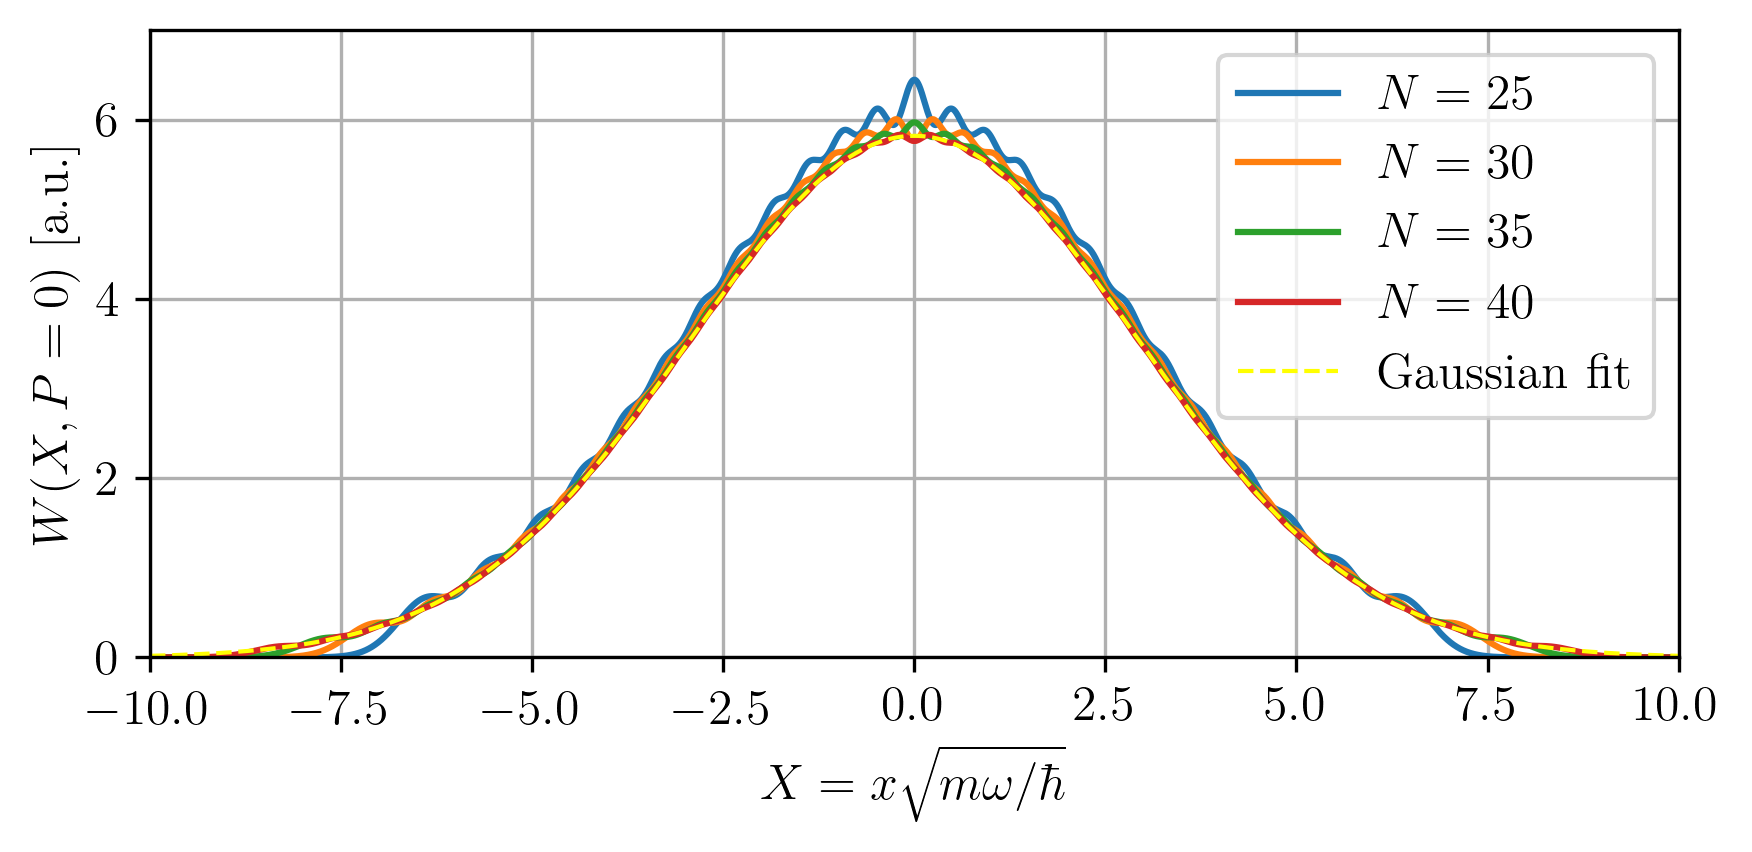

In [24]:
vals = numpy.diag(pt)

def my_func(x, p):
    for i, val in enumerate(vals):
        if i == 0:
            result = val * wigner(i)(x, p)
        else:
            result += val * wigner(i)(x, p)
    return result

def gaussian(x, a, b):
    return numpy.exp(-x**2 / b**2) * a

test_x = numpy.linspace(-10, 10, 10001)
test_40 = my_func(test_x, 0)

#pyplot.plot(test_x, numpy.exp(-test_x**2))

fig = pyplot.figure(figsize=(6, 3), tight_layout=True)
ax = fig.add_subplot(1, 1, 1)

ax.plot(test_x, 100*test_25, label="$N=25$")
ax.plot(test_x, 100*test_30, label="$N=30$")
ax.plot(test_x, 100*test_35, label="$N=35$")
ax.plot(test_x, 100*test_40, label="$N=40$")

popt, pcov = optimize.curve_fit(gaussian, test_x, 100*test_40)
perr = numpy.sqrt(numpy.diag(pcov))
pyplot.plot(test_x, gaussian(test_x, *popt), "--", c="#ffff00", alpha=1, lw=1, label="Gaussian fit")
print(popt[1], "+-", perr[1])

ax.grid()
ax.set_xlim(-10, 10)
ax.set_ylim(0, 7)
ax.set_xlabel("$X=x\\sqrt{m\\omega/\\hbar}$")
ax.set_ylabel("$W(X,P=0)$ [a.u.]")
ax.legend()

pyplot.gcf().set_dpi(300)
pyplot.savefig("SL_1cl_wigner.pdf")
pyplot.show()

## Run trajectories

In [4]:
def my_func2():
    return solve_mbaoab(-9.309, 0, 100000)

results = joblib.Parallel(n_jobs=4)(joblib.delayed(my_func2)() for i in enumerate(tqdm(numpy.arange(1000))))
numpy.save("data/SL_1cl/trajectories_rand_x=-9.npy", numpy.array(results))
del results

#initial = -5
#results = joblib.Parallel(n_jobs=4)(joblib.delayed(my_func2)(initial) for i in enumerate(tqdm(numpy.arange(1000))))
#numpy.save("data/SL_1cl/trajectories" + str(initial) + "_" + str(lamda) + "_voltage_" + str(voltage) + ".npy", numpy.array(results))

#initial = -6
#results = joblib.Parallel(n_jobs=4)(joblib.delayed(my_func2)(initial) for i in enumerate(tqdm(numpy.arange(100))))
#numpy.save("data/SL_1cl/trajectorieslong" + str(initial) + "_" + str(lamda) + "_voltage_" + str(voltage) + ".npy", numpy.array(results))

## Plot trajectories

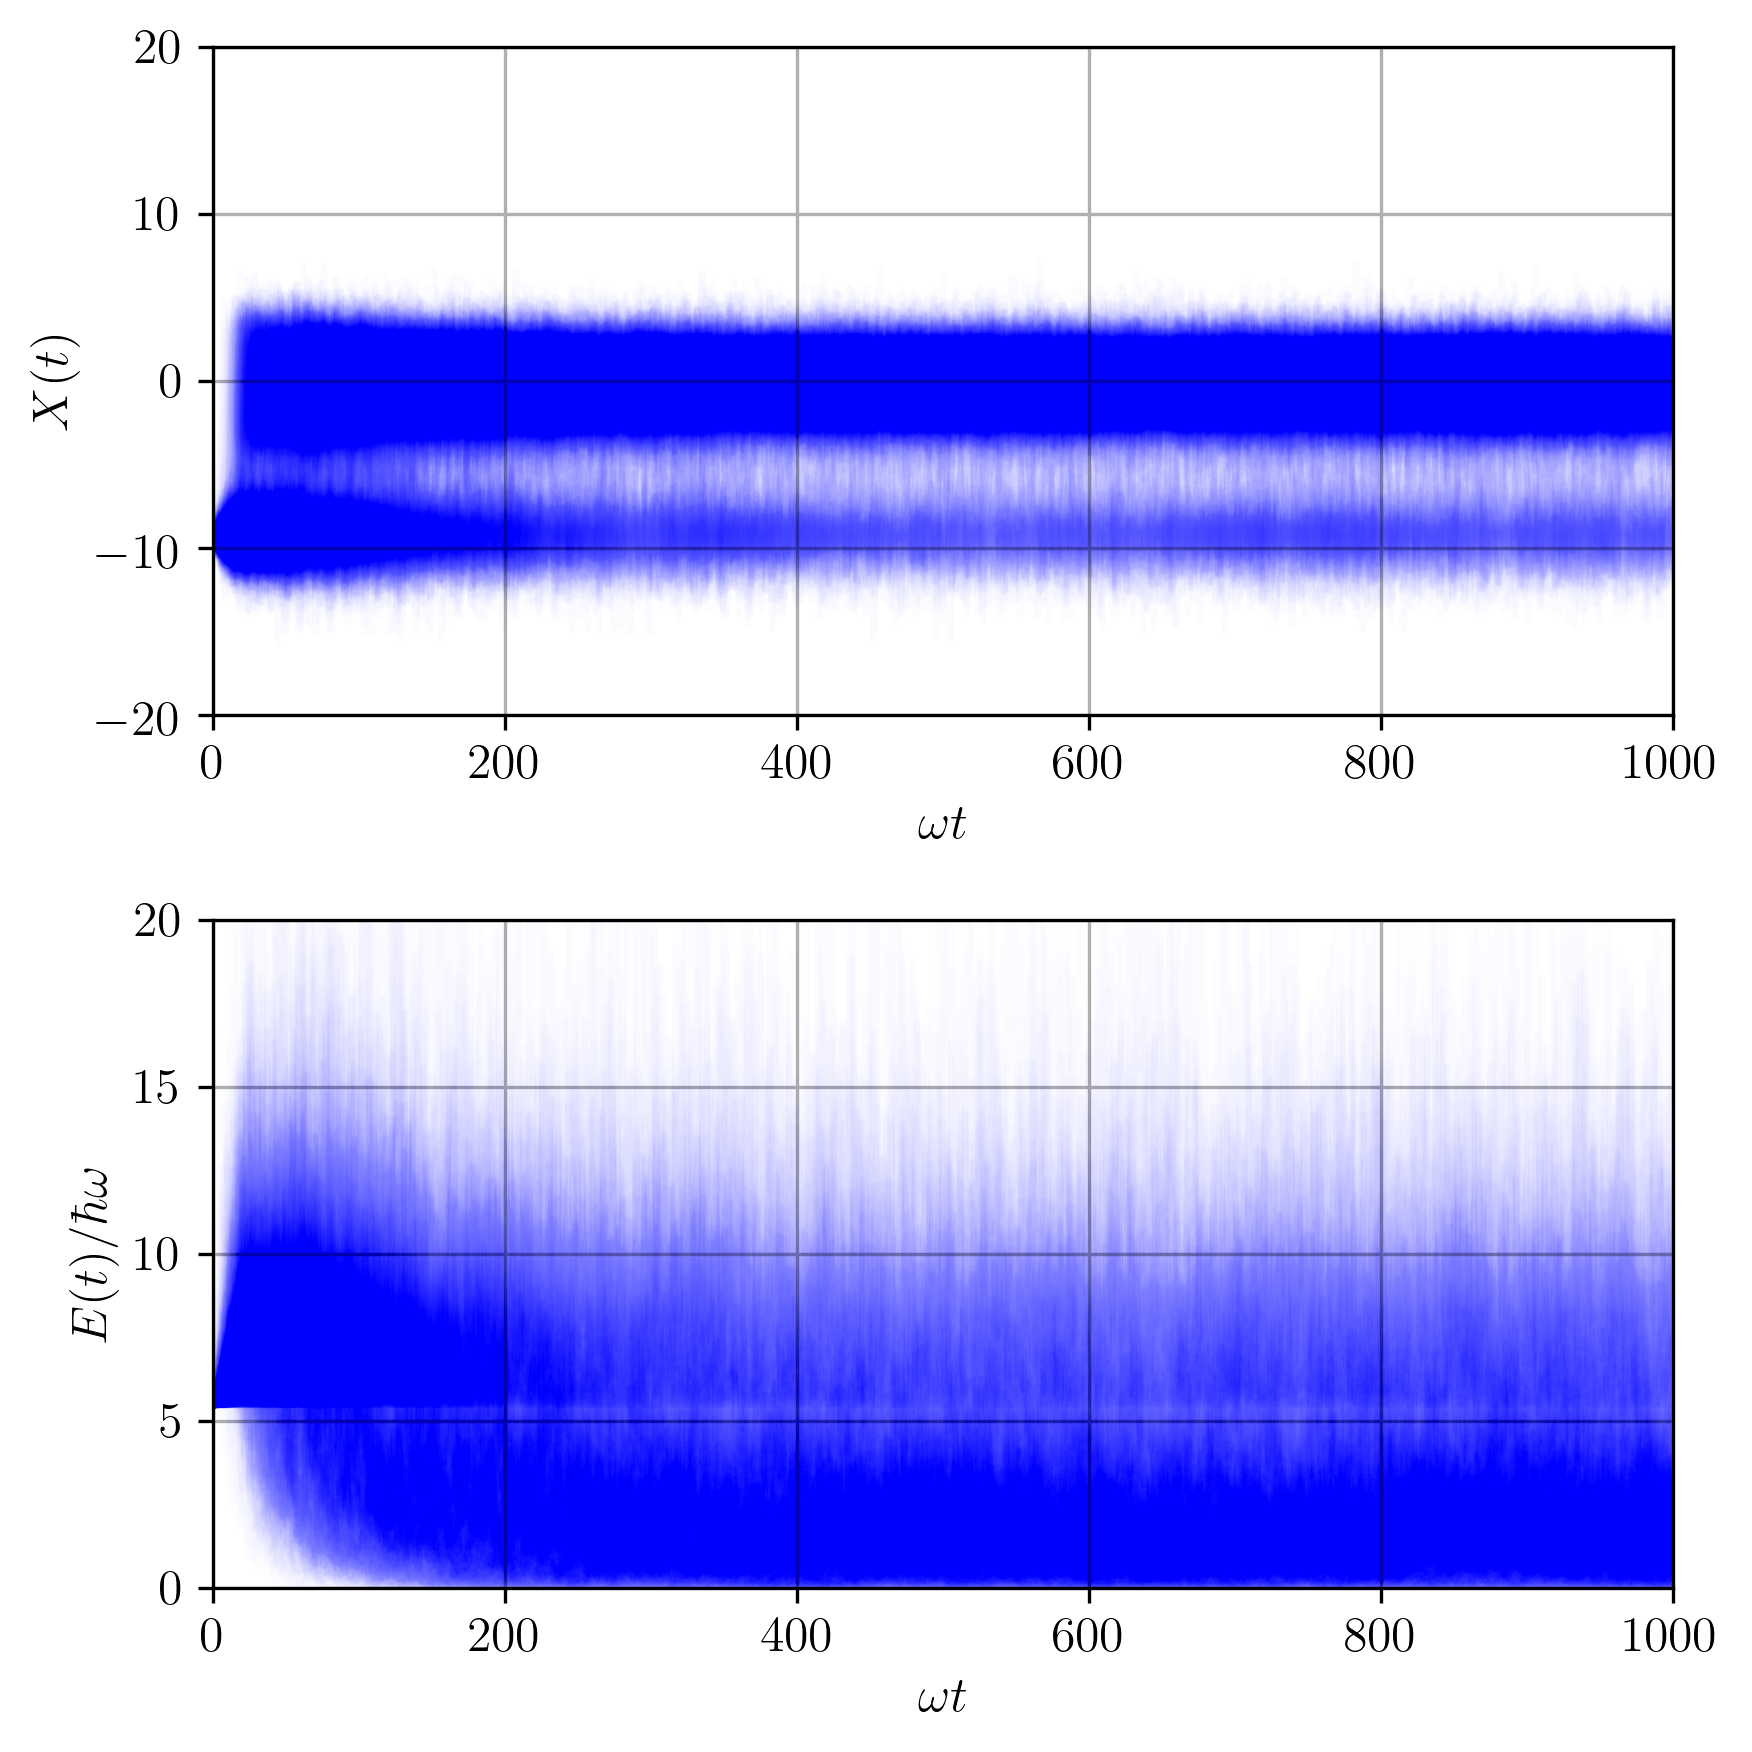

In [6]:
trajectories = numpy.load("data/SL_1cl/trajectories_rand_x=-9.npy")

fig = pyplot.figure(figsize=(6, 6), tight_layout=True)
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

for i in tqdm(range(trajectories.shape[0])):
    x_sol = trajectories[i,0]
    v_sol = trajectories[i,1]
    ax1.plot(numpy.arange(len(x_sol))*1e-2, x_sol, c="blue", alpha=0.01)
#    ax.plot(numpy.arange(len(x_sol))*1e-2, get_lin_int(x_sol, pmf), c="red")#, alpha=0.1)
    ax2.plot(numpy.arange(len(x_sol))*1e-2, get_lin_int(x_sol, pmf) + 0.5 * v_sol**2, c="blue", alpha=0.007)
#    ax.plot(numpy.arange(len(x_sol))*1e-2, 0.5 * v_sol**2, c="blue")#, alpha=0.1)

ax1.set_xlabel("$\\omega t$")
ax1.set_ylabel("$X(t)$")
ax1.set_xlim(0, 1000)
ax1.set_ylim(-20, 20)
ax1.grid()

ax2.set_xlabel("$\\omega t$")
ax2.set_ylabel("$E(t)/\\hbar\\omega$")
ax2.set_xlim(0, 1000)
ax2.set_ylim(0, 20)
ax2.grid()

pyplot.gcf().set_dpi(300)
pyplot.savefig("SL_1cl_trajectories_x=-9.png")
pyplot.show()

del trajectories

In [8]:
import gc
gc.collect()

20